# Thai Toxic Detection with BERT

In [113]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [114]:
!ls /content/gdrive/MyDrive/NLP_Project

 1803.03662.pdf
 1809.08651v1.pdf
'198760-Article Text-757015-1-10-20191202 (1).pdf'
 1_W32.pdf
'243329-Article Text-853051-3-10-20210601.pdf'
'hate_speech - Copy.csv'
 hate_speech.csv
 saved_weights_01.pt


In [115]:
!nvidia-smi

Tue Nov 30 03:59:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |  10525MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [116]:
# !pip install -q -U watermark

In [117]:
!pip install -qq transformers

In [118]:
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

In [119]:
#@title Setup & Config
import transformers
# from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

In [121]:
df = pd.read_csv("/content/gdrive/MyDrive/NLP_Project/hate_speech - Copy.csv")
df.head()

,Text,is_toxic
0,วันๆ นี่คุยกะหมา แมว หมู ไก่ ม้า ควาย มากกว่าค...,0
1,หล่อมากกก หล่อวัวตายควายล้มกันเลยทีเดียวววว,0
2,สิวเหี้ยไรขึ้นหลังหู เสียชาติเกิดมั้ย เกิดมามั...,0
3,อ่ะ ป่วยก็ป่วย งานจ้างก็ต้องทำ งานเรียนก็ต้องท...,0
4,นี่ก็เพิ่งรู้ว่า เกิดชาตินี้ชาติเดียว เป็นทั้ง...,1


In [122]:
df.shape

(4394, 2)

Let's check for missing values:

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4394 entries, 0 to 4393
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      4394 non-null   object
 1   is_toxic  4394 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.8+ KB


Great, no missing values in the score and review texts! Do we have class imbalance?

In [124]:
df['is_toxic'].value_counts()

1    2322
0    2072
Name: is_toxic, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


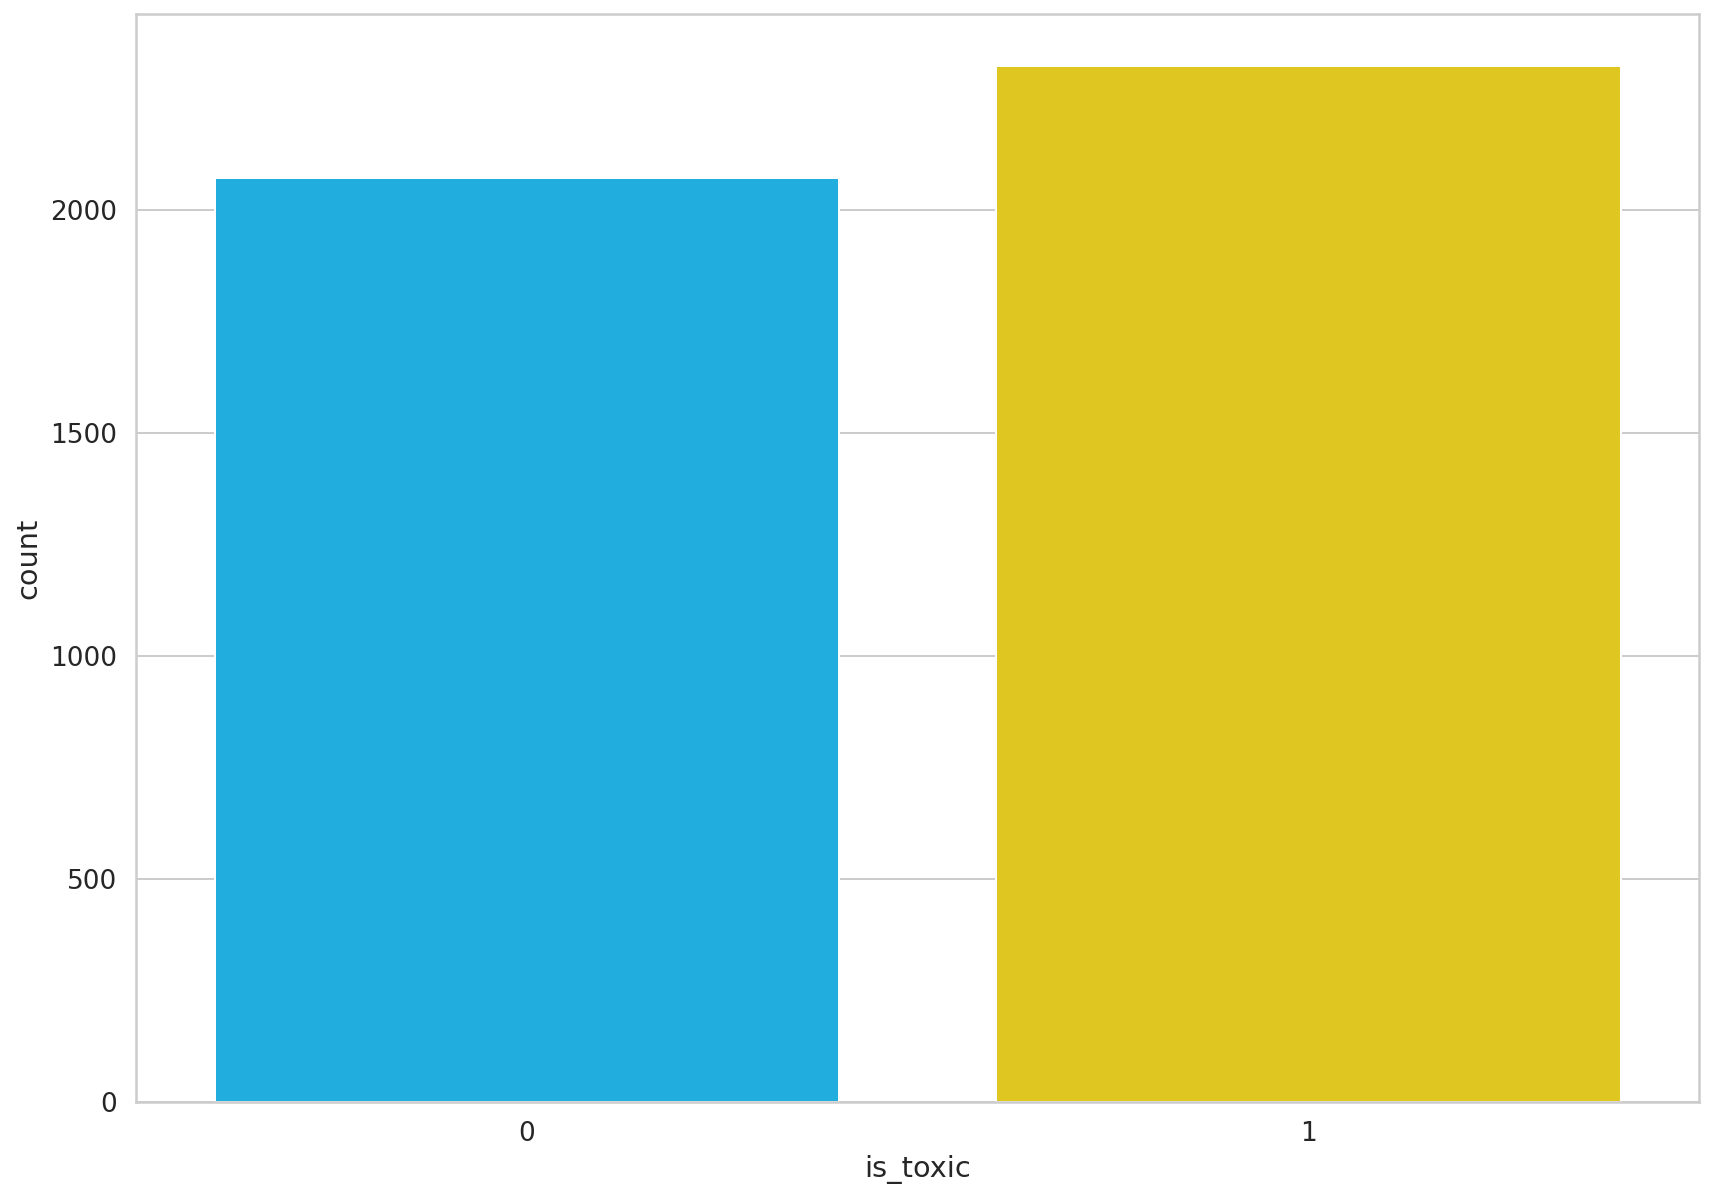

In [125]:
sns.countplot(df['is_toxic'])
plt.xlabel('is_toxic');

That's almost balanced. We're going to convert the dataset into hate speech and normal:

In [126]:
class_names = ['Not Hate speech', 'Hate speech']

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [127]:
PRE_TRAINED_MODEL_NAME = "Geotrend/bert-base-th-cased"#@param ["monsoon-nlp/bert-base-thai", "bert-base-multilingual-uncased", "Geotrend/bert-base-th-cased"] 

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [128]:
# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [129]:
sample_txt = 'ฉันจะพาเธอลอยล่องไปในอวกาศที่มีแต่เธอ มีแต่เธอ และไม่ต้องกลัว'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [130]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: ฉันจะพาเธอลอยล่องไปในอวกาศที่มีแต่เธอ มีแต่เธอ และไม่ต้องกลัว
   Tokens: ['ฉ', '##ัน', '##จ', '##ะ', '##พ', '##า', '##เธอ', '##ล', '##อย', '##ล', '##่อ', '##ง', '##ไ', '##ป', '##ใน', '##อ', '##ว', '##ก', '##า', '##ศ', '##ที่', '##มี', '##แ', '##ต', '##่', '##เธอ', 'ม', '##ี', '##แ', '##ต', '##่', '##เธอ', 'และ', '##ไ', '##ม', '##่', '##ต', '##้อง', '##ก', '##ล', '##ัว']
Token IDs: [144, 4054, 6284, 3894, 5795, 2930, 8301, 3554, 8261, 3554, 8226, 3316, 8488, 6457, 7654, 5136, 4953, 3167, 2930, 6522, 3119, 8207, 8485, 4799, 5013, 8301, 167, 3132, 8485, 4799, 5013, 8301, 2493, 8488, 2939, 5013, 4799, 7652, 3167, 3554, 7265]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [131]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 12)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [132]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 11)

There is also a special token for padding:

In [133]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [134]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 10)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [135]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [136]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  11,  144, 4054, 6284, 3894, 5795, 2930, 8301, 3554, 8261, 3554, 8226,
        3316, 8488, 6457, 7654, 5136, 4953, 3167, 2930, 6522, 3119, 8207, 8485,
        4799, 5013, 8301,  167, 3132, 8485, 4799,   12])

The attention mask has the same length:

In [137]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

We can inverse the tokenization to have a look at the special tokens:

In [138]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'ฉ',
 '##ัน',
 '##จ',
 '##ะ',
 '##พ',
 '##า',
 '##เธอ',
 '##ล',
 '##อย',
 '##ล',
 '##่อ',
 '##ง',
 '##ไ',
 '##ป',
 '##ใน',
 '##อ',
 '##ว',
 '##ก',
 '##า',
 '##ศ',
 '##ที่',
 '##มี',
 '##แ',
 '##ต',
 '##่',
 '##เธอ',
 'ม',
 '##ี',
 '##แ',
 '##ต',
 '[SEP]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [139]:
token_lens = []

for txt in df['Text']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


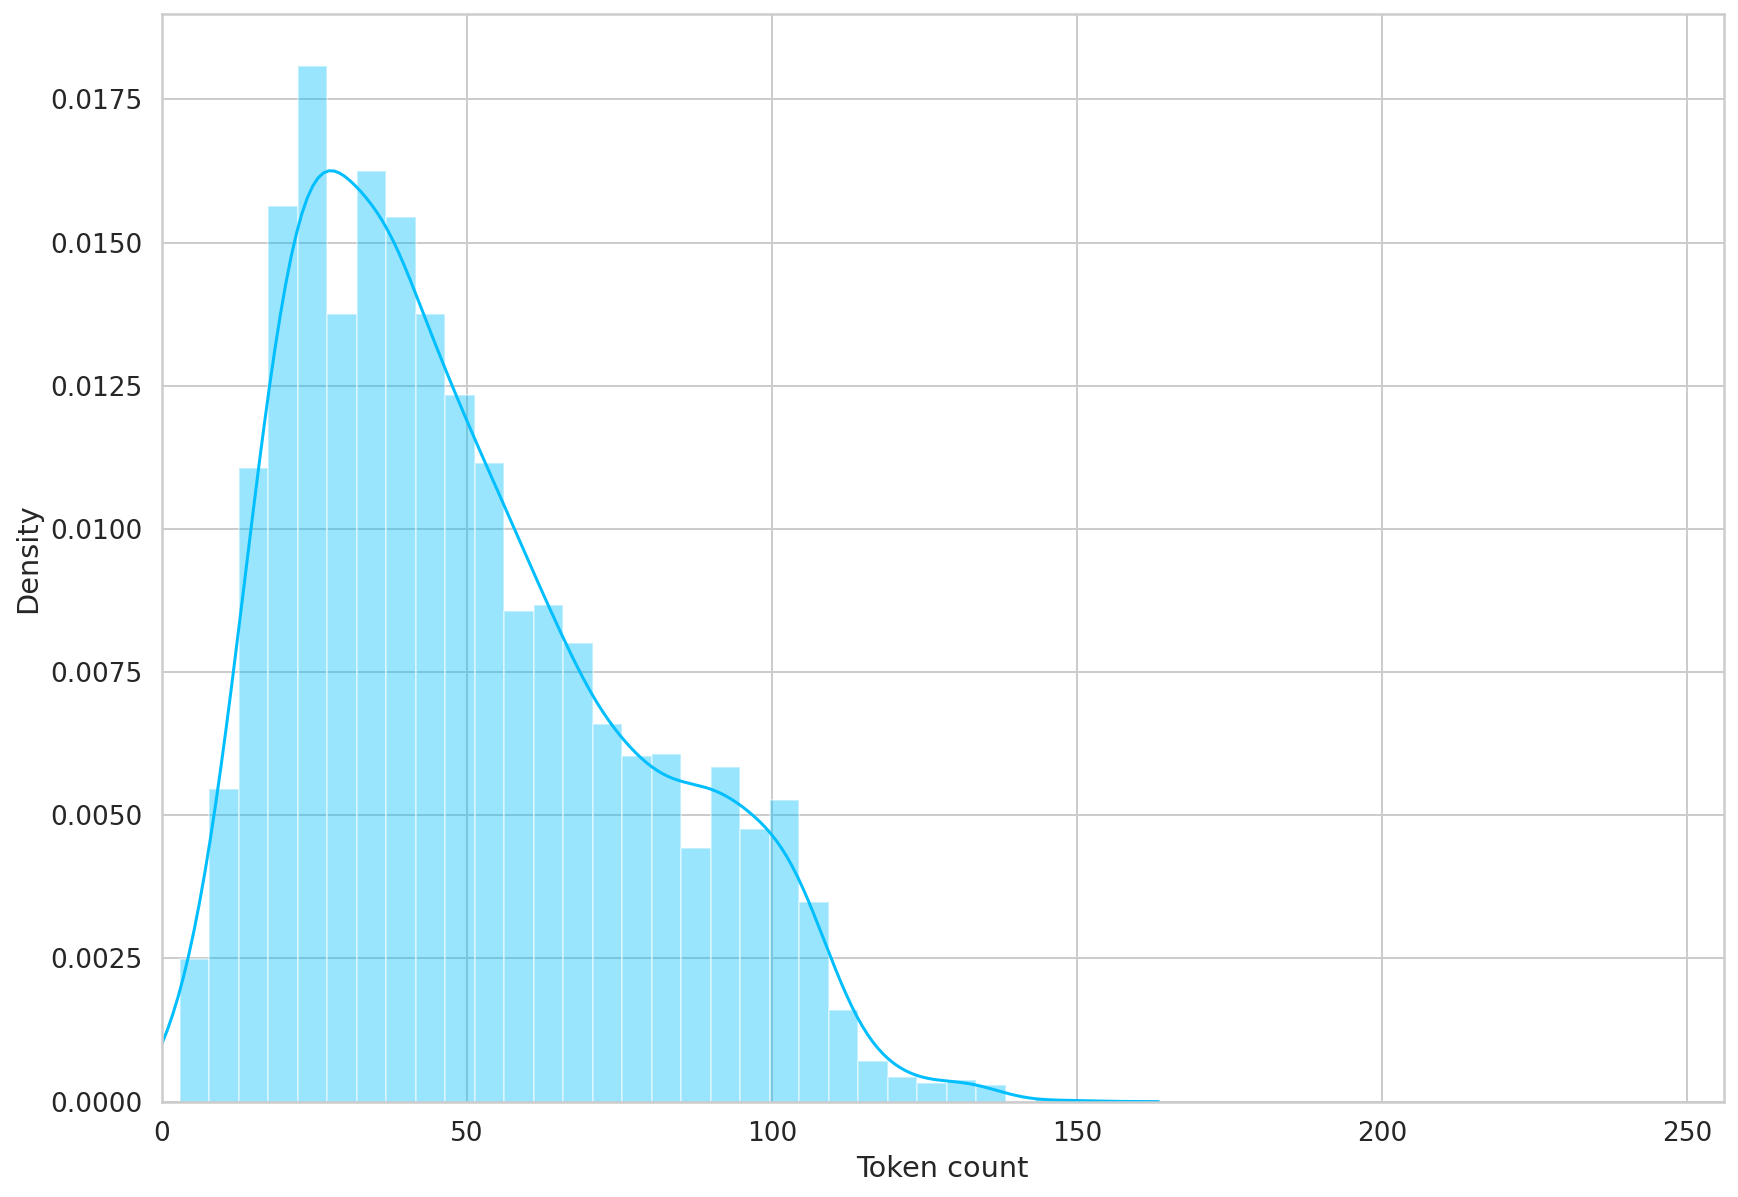

In [140]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 150.

In [141]:
MAX_LEN = 150

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [142]:
class HateSpeechDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

    def __len__(self):
    return len(self.reviews)

    def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      # pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

It'll be easier to evaluate the predictions from our model. Let's split the data:

In [143]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [144]:
df_train.shape, df_val.shape, df_test.shape

((3515, 2), (439, 2), (440, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [145]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = HateSpeechDataset(
      reviews=df['Text'].to_numpy(),
      targets=df['is_toxic'].to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [146]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [147]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [148]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


## Text Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [149]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at Geotrend/bert-base-th-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at Geotrend/bert-base-th-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.

And try to use it on the encoding of our sample text:

In [150]:
model_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [151]:
model_output.last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [152]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [153]:
model_output.pooler_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [154]:
class HateClassifier(nn.Module):

    def __init__(self, n_classes):
    super(HateClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
    model_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(model_output.pooler_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [155]:
model = HateClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at Geotrend/bert-base-th-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at Geotrend/bert-base-th-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.

We'll move the example batch of our training data to the GPU:

In [156]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [157]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5173, 0.4827],
        [0.5306, 0.4694],
        [0.5291, 0.4709],
        [0.4827, 0.5173],
        [0.5579, 0.4421],
        [0.5397, 0.4603],
        [0.5635, 0.4365],
        [0.4984, 0.5016],
        [0.4692, 0.5308],
        [0.4766, 0.5234],
        [0.4934, 0.5066],
        [0.4943, 0.5057],
        [0.5148, 0.4852],
        [0.4333, 0.5667],
        [0.4326, 0.5674],
        [0.5282, 0.4718]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [158]:
EPOCHS = 40

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [159]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
    ):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [160]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [161]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/NLP_Project/best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/40
----------
Train loss 0.7017456331036308 accuracy 0.5012802275960171
Val   loss 0.6927927391869682 accuracy 0.5375854214123007

Epoch 2/40
----------
Train loss 0.6959223411299965 accuracy 0.5081081081081081
Val   loss 0.6951035282441548 accuracy 0.44646924829157175

Epoch 3/40
----------
Train loss 0.6863493298942392 accuracy 0.5556187766714082
Val   loss 0.6610488849026817 accuracy 0.6173120728929384

Epoch 4/40
----------
Train loss 0.6751662797548554 accuracy 0.5718349928876245
Val   loss 0.6894013934901783 accuracy 0.5831435079726651

Epoch 5/40
----------
Train loss 0.6679918505928734 accuracy 0.5780938833570413
Val   loss 0.6715175445590701 accuracy 0.5649202733485194

Epoch 6/40
----------
Train loss 0.6556661695241928 accuracy 0.6170697012802276
Val   loss 0.6637474883879934 accuracy 0.633257403189066

Epoch 7/40
----------
Train loss 0.655215207148682 accuracy 0.6002844950213372
Val   loss 0.6758677469832557 accuracy 0.5489749430523918

Epoch 8/40
----------
Train 

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

We can look at the training vs validation accuracy:

In [162]:
model_save_name = 'saved_weights.pt'
path = f"/content/gdrive/MyDrive/NLP_Project/{model_save_name}"
torch.save(model.state_dict(), path)

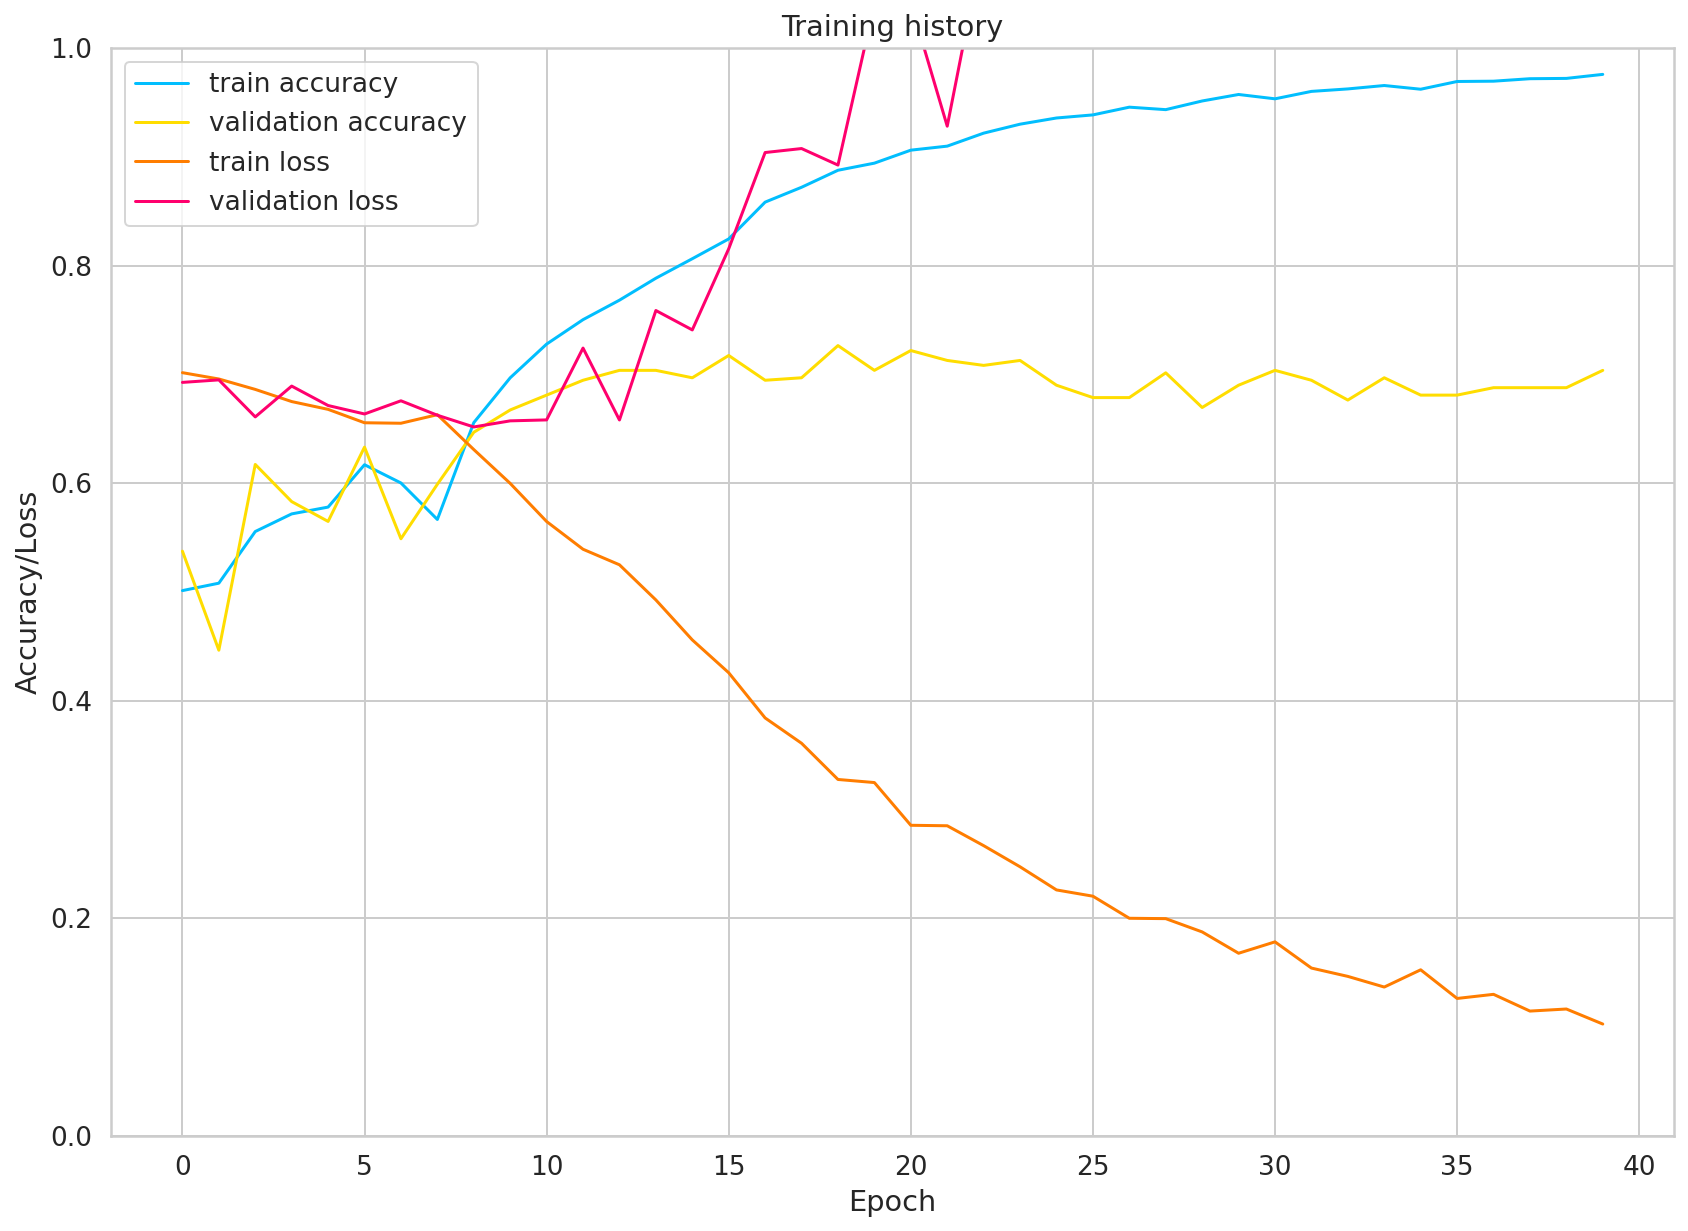

In [163]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

Let's start by calculating the accuracy on the test data:

In [165]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7159090909090908

Let's get prediction

In [166]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
    for d in data_loader:

        texts = d["review_text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        probs = F.softmax(outputs, dim=1)

        review_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(probs)
        real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [176]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [178]:
print(classification_report(y_test, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

Not Hate speech       0.74      0.62      0.67       208
    Hate speech       0.70      0.80      0.75       232

       accuracy                           0.72       440
      macro avg       0.72      0.71      0.71       440
   weighted avg       0.72      0.72      0.71       440



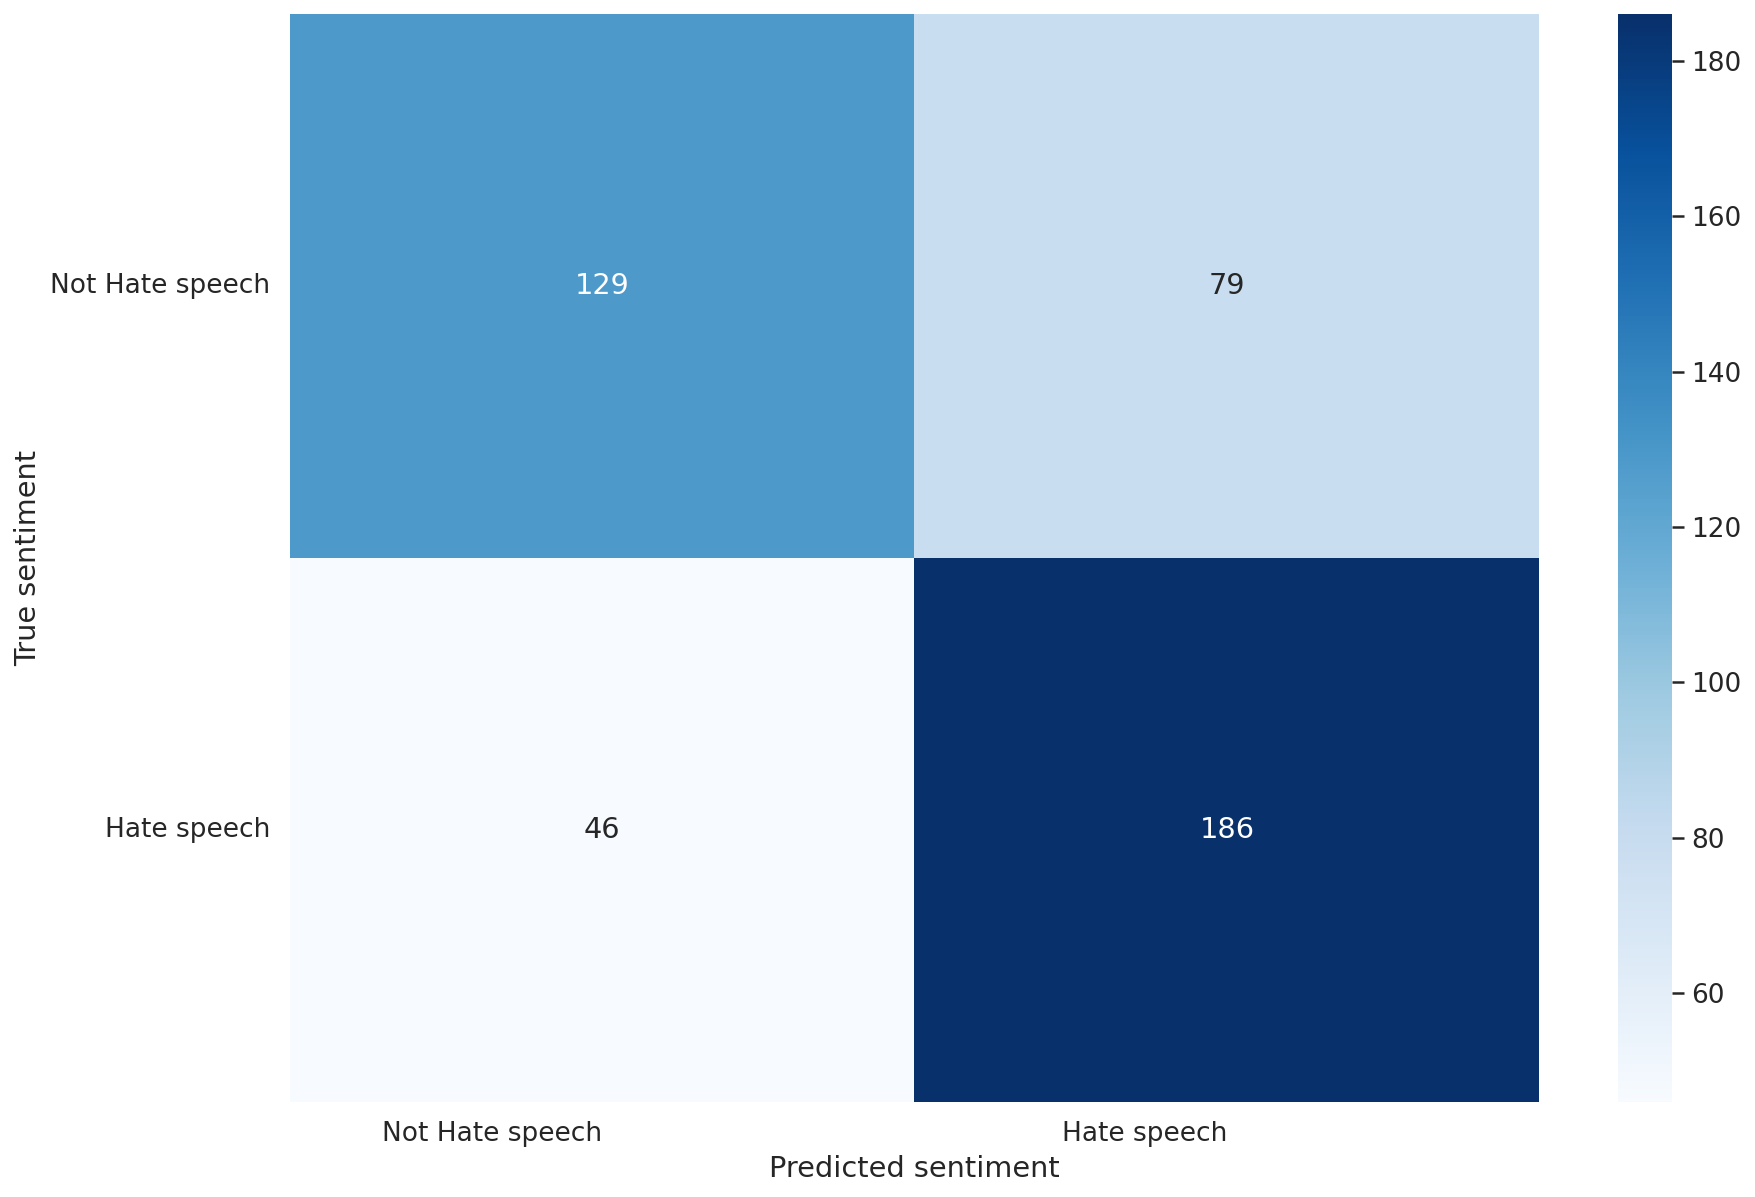

In [179]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [180]:
idx = 10

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [181]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

อย่าทำตัวกะหรี่

True sentiment: Hate speech


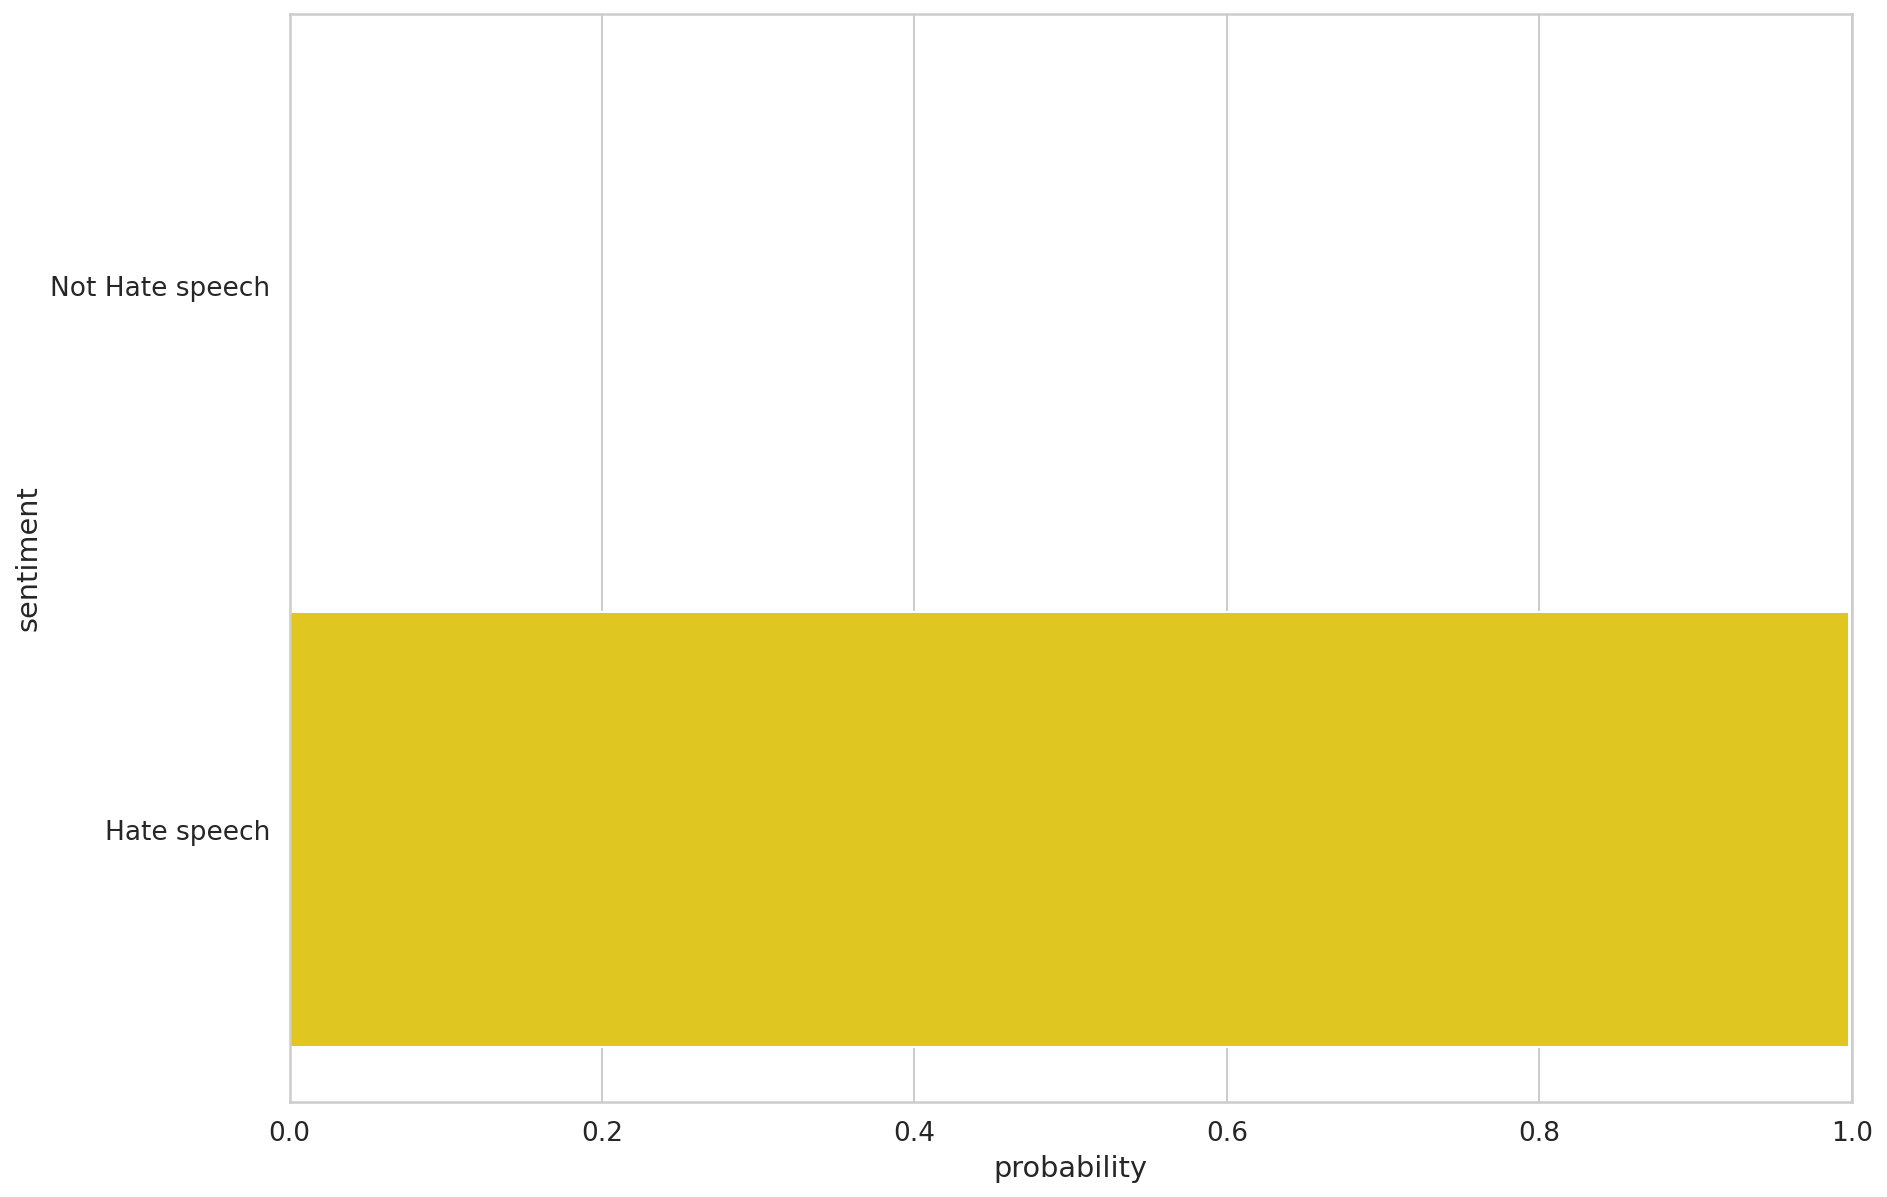

In [172]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [173]:
review_text = "ฉันจะพาเธอลอยล่องไปในอวกาศที่มีแต่เธอ มีแต่เธอ"

We have to use the tokenizer to encode the text:

In [174]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Let's get the predictions from our model:

In [175]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: ฉันจะพาเธอลอยล่องไปในอวกาศที่มีแต่เธอ มีแต่เธอ
Sentiment  : Not Hate speech
Review text: ฉันจะพาเธอลอยล่องไปในอวกาศที่มีแต่เธอ มีแต่เธอ
Sentiment  : Not Hate speech
